<a href="https://colab.research.google.com/github/AeMcRa/Datascience-things/blob/main/AedaRamoU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What Is The True Average Minimum Path Length In My Game?

I am making a game for the LASA Game Development Club that has a bunch of levels laid out like a web. There are various paths that the player can take through the level, but at least for now, I want to predict the shortest path to the end of the level(Stay tuned for part 2, Predicting Maximum Path Length In My Game!)

Having this information is incredibly important as a game designer, as it will help me tune the experience of playing the game, because there is a sweet spot between having a consistant and fair experience, and having a varied and unique experience. Unfortunately, I cannot simply look into the code of the game because Pastafarianist high priest Malcolmb Roalson's esoteric sphagetti code is unitelligable. So instead I decided to run a script to generate 200 instances of the game and then model them statistically.


# On to the Data!


In [3]:
!pip install "preliz"


#Importing libraries! This code is copied from the notes.

import preliz as pz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 9.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


In [4]:
#import data, taken from notes
url_minGameLen = 'https://raw.githubusercontent.com/AeMcRa/Datascience-things/refs/heads/main/LevelLength.csv'
data_minGameLen = pd.read_csv(url_minGameLen)

data_minGameLen


,4.93
0,5
1,5
2,6
3,4
4,4
...,...
195,8
196,4
197,4
198,5


(array([ 5.,  0., 27.,  0.,  0., 49.,  0.,  0., 55.,  0.,  0., 36.,  0.,
         0., 17.,  0.,  0., 10.,  0.,  1.]),
 array([2.  , 2.35, 2.7 , 3.05, 3.4 , 3.75, 4.1 , 4.45, 4.8 , 5.15, 5.5 ,
        5.85, 6.2 , 6.55, 6.9 , 7.25, 7.6 , 7.95, 8.3 , 8.65, 9.  ]),
 <BarContainer object of 20 artists>)

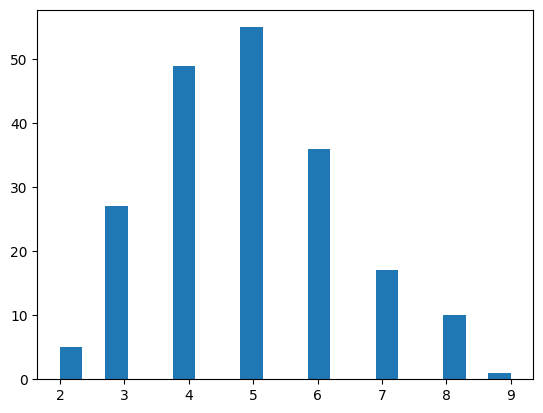

In [5]:
plt.hist(data_minGameLen,bins = 20)

# Describing our data
The data seems to be centered around 5, is relatively varied, and has a skew towards the left side, It seems to taper off exponentially to the right. The data is discreet in nature.

Due to these variables, I will tried model my data with two distributions, one continuous to get a more intuitive expression of the distribution of the data, and a discreet distribution to mirror the discreet nature of the data. The continous distribution will be an Exgaussian distribution, which takes in mean, variance, and skew priors, as well as a Poisson distribution, with takes in a mean prior. Lets start with our mean prior and Poisson distribution.

# Mean Prior:

From my playtesting, I noticed that the shortest path length tended to hover around 5, with the majority of the paths falling between 3 and 7. There are obviously no levels with 0 or negative length, and the shortest path rarely was longer than 8, with a length of 9 being extremely rare. These paramaters point to a gamma distribution, with a mean of 5, and a variance of 1.

<Axes: >

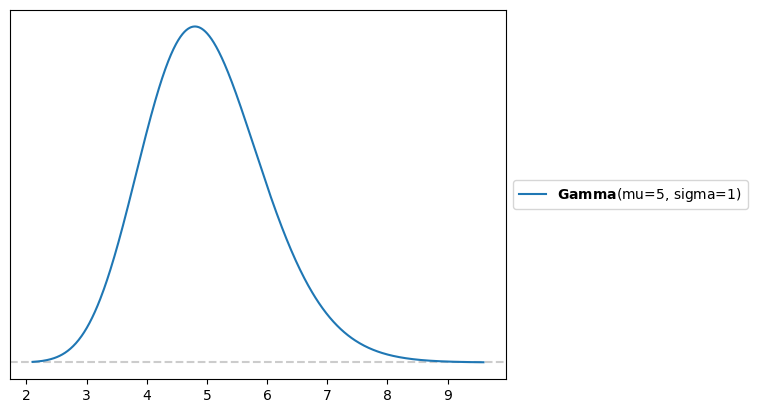

In [19]:
pz.Gamma(mu = 5, sigma = 1).plot_pdf()

# Time to plug this into our distributions and see what happens!

# Poisson:

In [115]:
#P for Poisson
with pm.Model() as model_minGameLenP:

    #mean prior
    μ = pm.Gamma('μ', mu = 5, sigma = 1)



    #our likelihood, with one prior
    Y = pm.Poisson('Y', mu = μ, observed=data_minGameLen)
    idata_minGameLenP = pm.sample()

Output()

Output()

In [116]:
pm.sample_posterior_predictive(idata_minGameLenP, model=model_minGameLenP, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

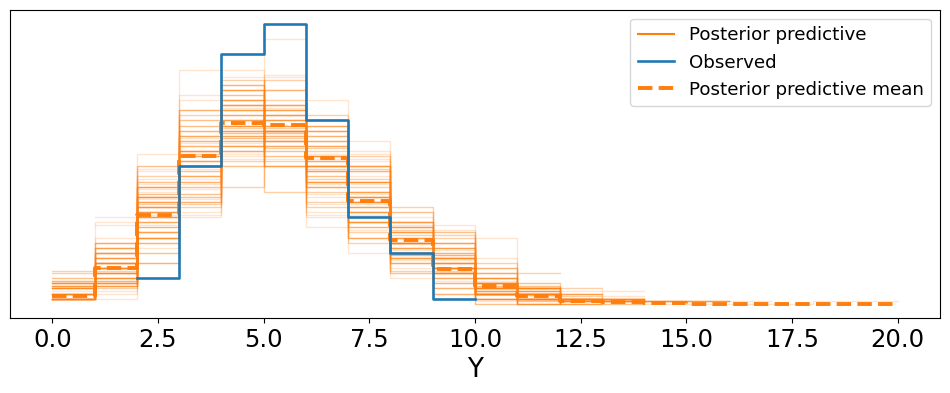

In [117]:
az.plot_ppc(idata_minGameLenP, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# Breaking it down
The poisson distribution is useful for seeing how a discreet model would work, but I think it simply lacks the shape parameters necessary to create a more accurate model. There is unfortunately no discreet model in the pymc library that would be able to accurately model this distribution of data, but if we are thinking theoretically, I think a version of the Poisson that has variance and kertosis priors would be able to more accurately model this distribution. I think Poisson makes more sense as a reflection of the context, becasue Poisson measures number of events taking place in a certain period of time or space, and if we look at this in terms of levels, the model is measuring how many levels occur in the shortest path before the space that is the end of the path.

# On to ExGaussian!



# Variance Prior
As stated earlier, it appears that the majority of instances are concentrated within 2 to 2.5 levels from 5, but I am not completely sure so I will use a normal distribution with a bit of uncertainty to model that.

<Axes: >

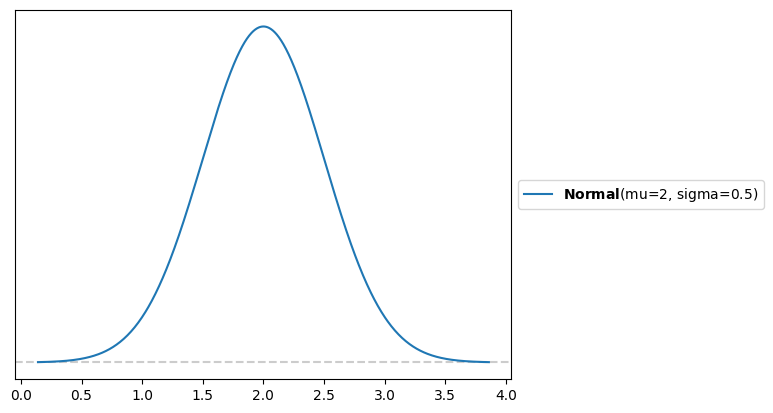

In [84]:
pz.Normal( mu = 2, sigma = 0.5).plot_pdf()

# Kurtosis Prior
Our data is pretty centralized around it's mean, so we will give it a decently high kurtosis. Since negative kurtosis can cause divergences, we will be using a gamma distribution.

<Axes: >

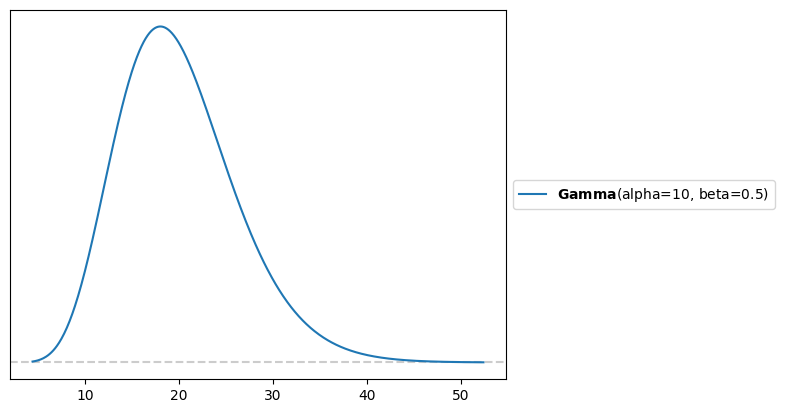

In [111]:
pz.Gamma(alpha=10,beta=0.5).plot_pdf()

# ExGaussian

In [112]:
#XG for ExGaussian
with pm.Model() as model_minGameLenXG:

    #mean prior
    μ = pm.Gamma('μ', mu= 5, sigma=1)

    #variance prior
    σ = pm.Normal('σ', mu = 2, sigma = .5)

    #kurtosis prior
    ν = pm.Gamma('ν', alpha=10, beta=.5)

    #our likelihood, with three priors
    Y = pm.ExGaussian('Y', mu = μ, sigma = σ, nu = ν, observed=data_minGameLen)
    idata_minGameLenXG = pm.sample()

Output()

Output()

In [113]:
pm.sample_posterior_predictive(idata_minGameLenXG, model=model_minGameLenXG, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

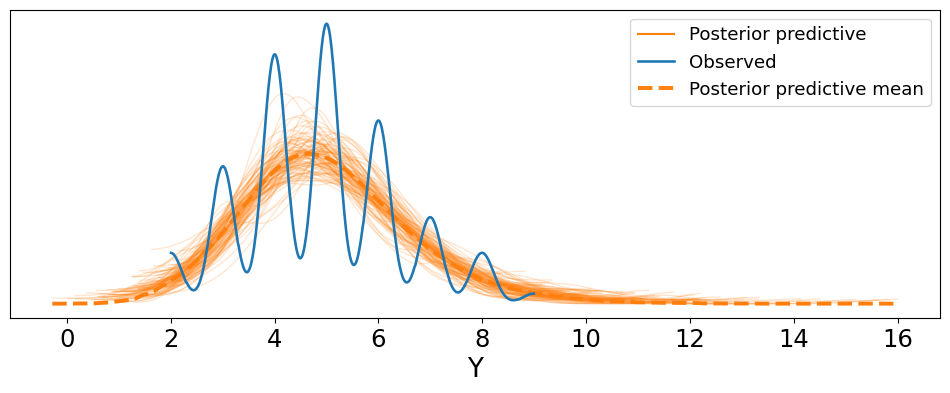

In [114]:
az.plot_ppc(idata_minGameLenXG, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# Breaking it down

Of the two posteriors, I think that the ExGaussian model more accurately predicted the distribution of minimum path lengths. It's curve matches up similarily to the curve of our data. Unfortunately, since the data is discreet and the curve is continuous, the graph looks a bit off, but since the distribution should be directly proportional to the data, I think it is still an accurate predictor.



# Final Notes
There were a few issues with my model. Namely, bugs in the game itself. There were two main bugs here, one which randomly causes the game to crash, depriving me of data, and one which returns a value of 0, It is important to note that a value of zero means that instead of starting at the start of the game, you start at the end, so I threw out these instances as bugs.